In [1]:
#Simulation Test to verify the units
using LinearAlgebra
using ForwardDiff
using SatelliteDynamics
using DifferentialEquations
using Plots

In [2]:
#parameters for Earth Moon System
μ = 1.215e-2
μ1 = 1-μ
μ2 = μ

#position of mass 1
pose_m1 = [-μ, 0, 0]

#position of mass 2
pose_m2 = [1-μ, 0, 0]

#value obtained from 3BP textbook (original)
L = 3.850e5 #in km - distance between centers of m1 and m2
V_ = 1.025 #in km/s - orbital velocity of m1
T_ = 2.361e6 #in seconds - orbital period of m1 and m2
time_scale = T_/(2*pi)


#working
#########################################################################################
#updated for time unit to be in days
#T_ = 2.361e6/86400 #in days - orbital period of m1 and m2
#time_scale = T_/(2*pi)
#time unit of days
#V_ = L/time_scale
#acceleration_scale = L/((time_scale)^2)
##########################################################################################

#state of the L1 and L2 Lagrange points (computed offline)
XL1 = [0.8369180073169304, 0, 0, 0, 0, 0]
XL2 = [1.1556799130947355, 0, 0, 0, 0, 0]

6-element Vector{Float64}:
 1.1556799130947355
 0.0
 0.0
 0.0
 0.0
 0.0

In [3]:
function effective_potential(X)
    x = X[1]
    y = X[2]
    z = X[3]

    r1 = sqrt((x+μ2)^2 + y^2 + z^2) 
    r2 = sqrt((x-μ1)^2 + y^2 + z^2)
    #assuming m3 is unit mass
   
    U = (-μ1/r1)-(μ2/r2)-0.5*(x^2+y^2)
   
    return U
    
end

effective_potential (generic function with 1 method)

In [4]:
function three_body_prob_dynamics(x)
    
    q = zeros(eltype(x),3)
    v = zeros(eltype(x),3)
    q = x[1:3]
    v = x[4:6]

    ẋ = zeros(eltype(x),6)
    U_q = zeros(eltype(x),3)
    
    U_q = (ForwardDiff.gradient(_x -> effective_potential(_x), q))
        
    ẋ[1:3] = v
    ẋ[4] = 2*v[2] - U_q[1] 
    ẋ[5] = -2*v[1] - U_q[2]
    ẋ[6] = -U_q[3]

    return ẋ
end

three_body_prob_dynamics (generic function with 1 method)

In [5]:
#x[1:6] -> state
#x[7:9] -> control inputs

#coming in with SI units
function three_body_prob_dynamics_wcontrol(x)
    
    q = zeros(eltype(x),3)
    v = zeros(eltype(x),3)
    q = x[1:3]
    v = x[4:6]
    u = x[7:9]

    ẋ = zeros(eltype(x),9)
    
    U_q = zeros(eltype(x),3)
    
    U_q = (ForwardDiff.gradient(_x -> effective_potential(_x), q))
        
    ẋ[1:3] = v
    ẋ[4] = 2*v[2] - U_q[1] + u[1] 
    ẋ[5] = -2*v[1] - U_q[2] + u[2]
    ẋ[6] = -U_q[3] + u[3]
    
    #zero order hold on the controls 
    ẋ[7:9] = zeros(3)

    return ẋ
end

three_body_prob_dynamics_wcontrol (generic function with 1 method)

In [6]:
#solve using DifferentialEquations.jl
function ST_and_dynamics_DFJL_wcontrol!(du, u, p, t)
    
    #original CR3BP units
    #du[1:9] = three_body_prob_dynamics_wcontrol(u[1:9])

    #scaled units
    du[1:9] = three_body_prob_dynamics_wcontrol(u[1:9])
    
end

ST_and_dynamics_DFJL_wcontrol! (generic function with 1 method)

In [7]:
function dynamics_wcontrol_integrate(x_0,period)
    
    tspan = (0.0, period)
    prob = ODEProblem(ST_and_dynamics_DFJL_wcontrol!, x_0, tspan)
    #sol = solve(prob, TsitPap8(), abstol=1e-12, reltol=1e-12)

    sol = solve(prob, TsitPap8(), abstol=1e-15, reltol=1e-15)
    
    return sol
    
end

dynamics_wcontrol_integrate (generic function with 1 method)

In [8]:
#gets the state and transition matrix for the entire solution

function get_state_wcontrol(solution)
    
    N = size(solution.u)[1]

    all_states = zeros(9, N)

    for i=1:N
        all_states[:,i] = solution.u[i][1:9]
    end
    
    #all states and all stm are functions of t
    #solution.t is the time
    return all_states
end

get_state_wcontrol (generic function with 1 method)

In [9]:
function integrate_oneperiod(x_0, u)
    
    #u will be size 40 since we only want to apply the controls for one rev
    
    #x trajectory not delta x 

    xtraj = zeros(6, N_period)

    xtraj[:,1] = x_0

    for i=1:N_period-1
        
        #integrate the nonlinear dynamics 1 timstep forward
        x_0_non = [xtraj[:,i]; u[:,i]]

        solution_in = dynamics_wcontrol_integrate(x_0_non, Δt)
        #this is the next state
        all_state_next = get_state_wcontrol(solution_in)

        xtraj[:,i+1] = all_state_next[1:6, end]
    end
    
    #this is size N. 40 for this case
    return xtraj
        
end

integrate_oneperiod (generic function with 1 method)

In [10]:
N_period = 41

41

In [21]:
#period of 1 orbit in CR3BP units
period_1 = 3.414975413662902

#in cr3bp units
x0 = [1.1201297302380415,
 0.0,
 0.0059396759100811495,
 0.0,
 0.17677819141944426,
 0.0]

 x0_perturbation = x0 + [1e-6, 0, 0, 0, 1e-6, 0]

 #in cr3BP units
#Δt = 0.08537438534157255

Δt = 0.08537438526469196

0.08537438526469196

In [22]:
using DelimitedFiles
utraj  = readdlm("utraj.txt", ',')

3×4000 Matrix{Float64}:
 -3.88723e-5   -2.07866e-13  -9.39867e-14  …  -2.01865e-14  -1.53483e-14
 -3.6627e-5    -1.106e-12    -6.81707e-13     -7.51186e-12  -7.27653e-7
  2.61509e-12   2.36832e-14   2.74746e-14      4.87066e-15   1.93032e-12

In [ ]:
integrate_oneperiod(x_0)

In [23]:
#utraj will be size [3,4000]

function integrate_100revs(x_0, utraj)
    
    num_revs = 5
    all_x = zeros(6, N_period, num_revs)

    for i=1:num_revs

        all_x[:,:,i] = integrate_oneperiod(x_0, utraj[:,(40)*(i-1)+1:(40)*(i-1)+40])

        x_0 = all_x[:,end,i]

    end


    return all_x

end

integrate_100revs (generic function with 1 method)

In [24]:
utraj

3×4000 Matrix{Float64}:
 -3.88723e-5   -2.07866e-13  -9.39867e-14  …  -2.01865e-14  -1.53483e-14
 -3.6627e-5    -1.106e-12    -6.81707e-13     -7.51186e-12  -7.27653e-7
  2.61509e-12   2.36832e-14   2.74746e-14      4.87066e-15   1.93032e-12

In [25]:
all_x = integrate_100revs(x0, utraj)

6×41×5 Array{Float64, 3}:
[:, :, 1] =
 1.12013      1.12017      1.12036     …   1.11921      1.11889
 0.0          0.0150004    0.0294635      -0.0138616    0.00133896
 0.00593968   0.0058125    0.00544061      0.00579859   0.0059101
 0.0          0.00114152   0.00345887     -0.00397269  -0.00371617
 0.176778     0.173564     0.164314        0.175843     0.179168
 0.0         -0.00295996  -0.00569881  …   0.00280601  -0.000213836

[:, :, 2] =
  1.11889       1.11857      1.1183      …   1.05331      1.02746
  0.00133896    0.0165442    0.0312068      -0.0105762    0.0227232
  0.0059101     0.00576205   0.0053644       0.00211408   0.00270116
 -0.00371617   -0.00358716  -0.00237195     -0.193949    -0.447676
  0.179168      0.175951     0.166586        0.374785     0.367625
 -0.000213836  -0.00323442  -0.00602624  …   0.0134219   -0.00331708

[:, :, 3] =
  1.02746      0.977087      0.93417     …  -0.180248    -0.263441
  0.0227232    0.0380816     0.0169579       0.4679       0.438837

In [26]:
all_x[:,41,1]

6-element Vector{Float64}:
  1.1188855314430894
  0.0013389608668452659
  0.005910102970894425
 -0.003716170660690934
  0.1791681818712128
 -0.00021383642265228298

In [27]:
all_x 

6×41×5 Array{Float64, 3}:
[:, :, 1] =
 1.12013      1.12017      1.12036     …   1.11921      1.11889
 0.0          0.0150004    0.0294635      -0.0138616    0.00133896
 0.00593968   0.0058125    0.00544061      0.00579859   0.0059101
 0.0          0.00114152   0.00345887     -0.00397269  -0.00371617
 0.176778     0.173564     0.164314        0.175843     0.179168
 0.0         -0.00295996  -0.00569881  …   0.00280601  -0.000213836

[:, :, 2] =
  1.11889       1.11857      1.1183      …   1.05331      1.02746
  0.00133896    0.0165442    0.0312068      -0.0105762    0.0227232
  0.0059101     0.00576205   0.0053644       0.00211408   0.00270116
 -0.00371617   -0.00358716  -0.00237195     -0.193949    -0.447676
  0.179168      0.175951     0.166586        0.374785     0.367625
 -0.000213836  -0.00323442  -0.00602624  …   0.0134219   -0.00331708

[:, :, 3] =
  1.02746      0.977087      0.93417     …  -0.180248    -0.263441
  0.0227232    0.0380816     0.0169579       0.4679       0.438837

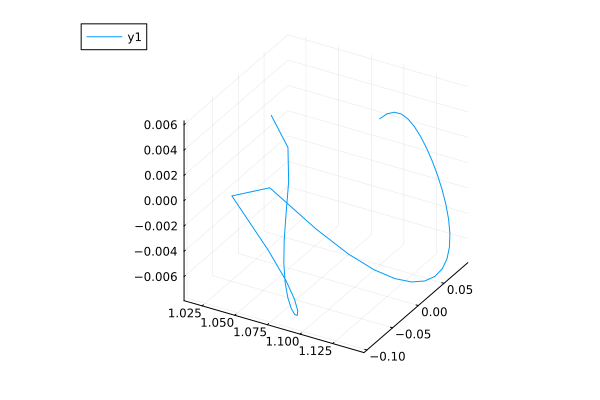

In [28]:
#simulation is off due to numerical error. very small Δu

plot(all_x[1,:,2], all_x[2,:,2], all_x[3,:,2])

#scatter!([all_x[1,end,1]], [all_x[2,end,1]], [all_x[3,end,1]])

# plot!(all_x[1,:,2], all_x[2,:,2], all_x[3,:,2])

# scatter!([all_x[1,1,2]], [all_x[2,1,2]], [all_x[3,1,2]])

# for i=2:100
#     plot!(all_x[1,:,i], all_x[2,:,i], all_x[3,:,i])
# end

# plot!(all_x[1,:,100], all_x[2,:,100], all_x[3,:,100])

In [132]:
Δt

0.08537438526469196

In [133]:
all_x 

6×41×1 Array{Float64, 3}:
[:, :, 1] =
 1.12013      1.12017      1.12036     …   1.11921      1.11889
 0.0          0.0150004    0.0294635      -0.0138616    0.00133896
 0.00593968   0.0058125    0.00544061      0.00579859   0.0059101
 0.0          0.00114159   0.00345895     -0.00397268  -0.00371617
 0.176778     0.173564     0.164314        0.175843     0.179168
 0.0         -0.00295996  -0.00569881  …   0.00280601  -0.000213843

In [134]:
1e-6*V_ 

1.025e-6

In [135]:
1e-6*L 

0.385

In [136]:
norm(all_x[1:3, 1, 1] - all_x[1:3, 41, 1])

0.0018280397243563458

In [ ]:
all_x[:,end,1]

In [ ]:
# #indexing working
# i = 3
# test = (40)*(i-1)+1
# test2 = (40)*(i-1)+40
# display(test)
# display(test2)

In [ ]:
utraj_ms2 = utraj.*acceleration_scale 

In [ ]:
#integrate over the timestep to get the velocity cost in km/s
x_cost = sum(abs.(utraj_ms2[1,:]))*(Δt*time_scale)
y_cost = sum(abs.(utraj_ms2[2,:]))*(Δt*time_scale)
z_cost = sum(abs.(utraj_ms2[3,:]))*(Δt*time_scale)

In [ ]:
x_cost_ms = x_cost*(1e3)
y_cost_ms = y_cost*(1e3)
z_cost_ms = z_cost*(1e3)

display(x_cost_ms)
display(y_cost_ms)
display(z_cost_ms)